In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import subprocess
import os
import pickle
import sys

sys.path.insert(0, '../src')

from utils import init_nodes
from spam_cluster import get_response_times
from pod_controller import get_loadbalancer_external_port, set_container_cpu_values

# Set the working directory to the root of the project
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
os.chdir(parent_dir)

print(f'Current working directory: {os.getcwd()}')


Current working directory: /home/jprodanov/resource-elastisity-nancy


In [2]:

interval = 1000
rps = 90

url = f"http://localhost:{get_loadbalancer_external_port(service_name='ingress-nginx-controller')}"
USERS = 10
recordings = 20
time_step = 1
action_interval = 1
initial_container_cpu = 50

nodes = init_nodes(debug=True, custom_label='app=localization-api')

apis = 3

first_loads = [0.6, 0.3, 0.1]
second_loads = [0.05, 0.3, 0.65]

algorithms = ['thold', 'dqn', 'ppo', 'ddpg']
crec_alg = {}
rts_alg = {}
num_iterations = 10

In [3]:
crec_alg = {algorithm: [] for algorithm in algorithms}
rts_alg = {algorithm: [] for algorithm in algorithms}

for algorithm in algorithms:
    for iterations in range(num_iterations):
        print(f'Algorithm: {algorithm}, Iteration: {iterations}')

        set_container_cpu_values(cpus=1000)
        for node in nodes:
            for container_id, (_, _, _) in list(node.get_containers().items()):
                (_, _, cpu_percentage), (_, _, _), (_, _), _ = node.get_container_usage(container_id)
                if cpu_percentage > 20:
                    time.sleep(1.5)
                else:
                    break
        set_container_cpu_values(cpus=initial_container_cpu)
        time.sleep(5)

        match algorithm:
            case 'thold':
                infer_process = subprocess.Popen(['python', 'src/threshold_elasticity.py'])
                print('Threshold elasticity started')
            case 'dqn':
                infer_process = subprocess.Popen(['python', 'src/infer.py', '--algorithm', 'mdqn',
                    '--action_interval', str(action_interval), '--load_model', 
                    'trained/dqn/mdqn1000ep1000m25inc2_rf_20rps5.0alpha1000res', '--hack', '2'])
                print('DQN started')
                time.sleep(15)
            case 'ppo':
                infer_process = subprocess.Popen(['python', 'src/infer.py',  '--algorithm',
                    'ppo','--load_model', 'trained/ppo/1000ep_rf_2_20rps10kepochs5alpha10epupdate50scale_a_1000resources',
                    '--action_interval', str(action_interval), '--hack', '0'])
                print('PPO started')
                time.sleep(15)
            case 'ddpg':
                infer_process = subprocess.Popen(['python', 'src/infer.py', '--algorithm',
                    'ddpg','--hack', '0', '--action_interval', str(action_interval), '--load_model', 
                    'trained/ddpg/1000ep_2rf_20rps5.0alpha_50scale1000resources'])
                print('DDPG started')
                time.sleep(15)

        container_recordings = []
        response_times = {api_id: [] for api_id in range(1, apis + 1)}

        commands = []
        for i, load in enumerate(first_loads):
            commands.append(['python', 'src/spam_cluster.py', '--users', str(int(rps * load)), 
                            '--interval', str(interval), '--service', str(i + 1)])

        subprocesses = [subprocess.Popen(command) for command in commands]

        try:
            for i in range(recordings):
                if i == (recordings // 2):
                    for proc in subprocesses:
                        proc.terminate()
                        proc.wait()
                    subprocesses.clear()
                    for api_id, load in enumerate(second_loads):
                        subprocesses.append(subprocess.Popen(
                            ['python', 'src/spam_cluster.py', '--users', str(int(rps * load)), 
                            '--interval', str(interval), '--service', str(api_id + 1)]))
                start_time = time.time()
                
                for api_id in range(1, apis + 1):
                    rts = [rt for rt in get_response_times(USERS, f'{url}/api{api_id}/predict') if rt is not None]
                    mean_rt = np.mean(rts) if rts else float('nan')
                    response_times[api_id].append(mean_rt)


                node_recordings = []
                for node in nodes:
                    for container_id, (_, _, _) in list(node.get_containers().items()):
                        (cpu_limit, cpu, cpu_percentage), (_, _, _), (_, _), _ = node.get_container_usage(container_id)
                        node_recordings.append((cpu_limit, cpu, cpu_percentage))
                container_recordings.append(node_recordings)

                elapsed_time = time.time() - start_time
                time.sleep(max(0, time_step - elapsed_time))
        finally:
            for proc in subprocesses:
                proc.terminate()
                proc.wait()

        crec_alg[algorithm].append(container_recordings)
        rts_alg[algorithm].append(response_times)
        infer_process.terminate()


mean_crec_alg = {algorithm: [[] for _ in range(recordings)] for algorithm in algorithms}
mean_rts_alg = {algorithm: {api_id: [] for api_id in range(1, apis + 1)} for algorithm in algorithms}

for algorithm in algorithms:
    for i in range(recordings):
        service_recordings = [[] for _ in range(apis)]
        for iteration in range(num_iterations):
            for service_idx, node_recording in enumerate(crec_alg[algorithm][iteration][i]):
                service_recordings[service_idx].append(node_recording)
        for service_idx, service_recording in enumerate(service_recordings):
            cpu_limits = [rec[0] for rec in service_recording]
            cpu_usages = [rec[1] for rec in service_recording]
            cpu_percentages = [rec[2] for rec in service_recording]
            mean_crec_alg[algorithm][i].append((
                np.mean(cpu_limits),
                np.mean(cpu_usages),
                np.mean(cpu_percentages)
            ))

    for api_id in range(1, apis + 1):
        for i in range(recordings):
            mean_rts = []
            for iteration in range(num_iterations):
                mean_rts.append(rts_alg[algorithm][iteration][api_id][i])
            mean_rts_alg[algorithm][api_id].append(np.mean(mean_rts))

Algorithm: thold, Iteration: 0
Threshold elasticity started
DEBUG: True, custom_app_label: app=localization-api, scale_cpu: 25, max_cpu: 1000, CPU limits: upper: 60, lower: 30, action_interval: 1
Algorithm: thold, Iteration: 1
Threshold elasticity started
DEBUG: True, custom_app_label: app=localization-api, scale_cpu: 25, max_cpu: 1000, CPU limits: upper: 60, lower: 30, action_interval: 1
Algorithm: thold, Iteration: 2
Threshold elasticity started
DEBUG: True, custom_app_label: app=localization-api, scale_cpu: 25, max_cpu: 1000, CPU limits: upper: 60, lower: 30, action_interval: 1
Algorithm: thold, Iteration: 3
Threshold elasticity started
DEBUG: True, custom_app_label: app=localization-api, scale_cpu: 25, max_cpu: 1000, CPU limits: upper: 60, lower: 30, action_interval: 1
Algorithm: thold, Iteration: 4
Threshold elasticity started
DEBUG: True, custom_app_label: app=localization-api, scale_cpu: 25, max_cpu: 1000, CPU limits: upper: 60, lower: 30, action_interval: 1
Algorithm: thold, It

In [9]:
pickle.dump(mean_crec_alg, open('results/monte_carlo_10/mean_crec_alg.p', 'wb'))
pickle.dump(mean_rts_alg, open('results/monte_carlo_10/mean_rts_alg.p', 'wb'))

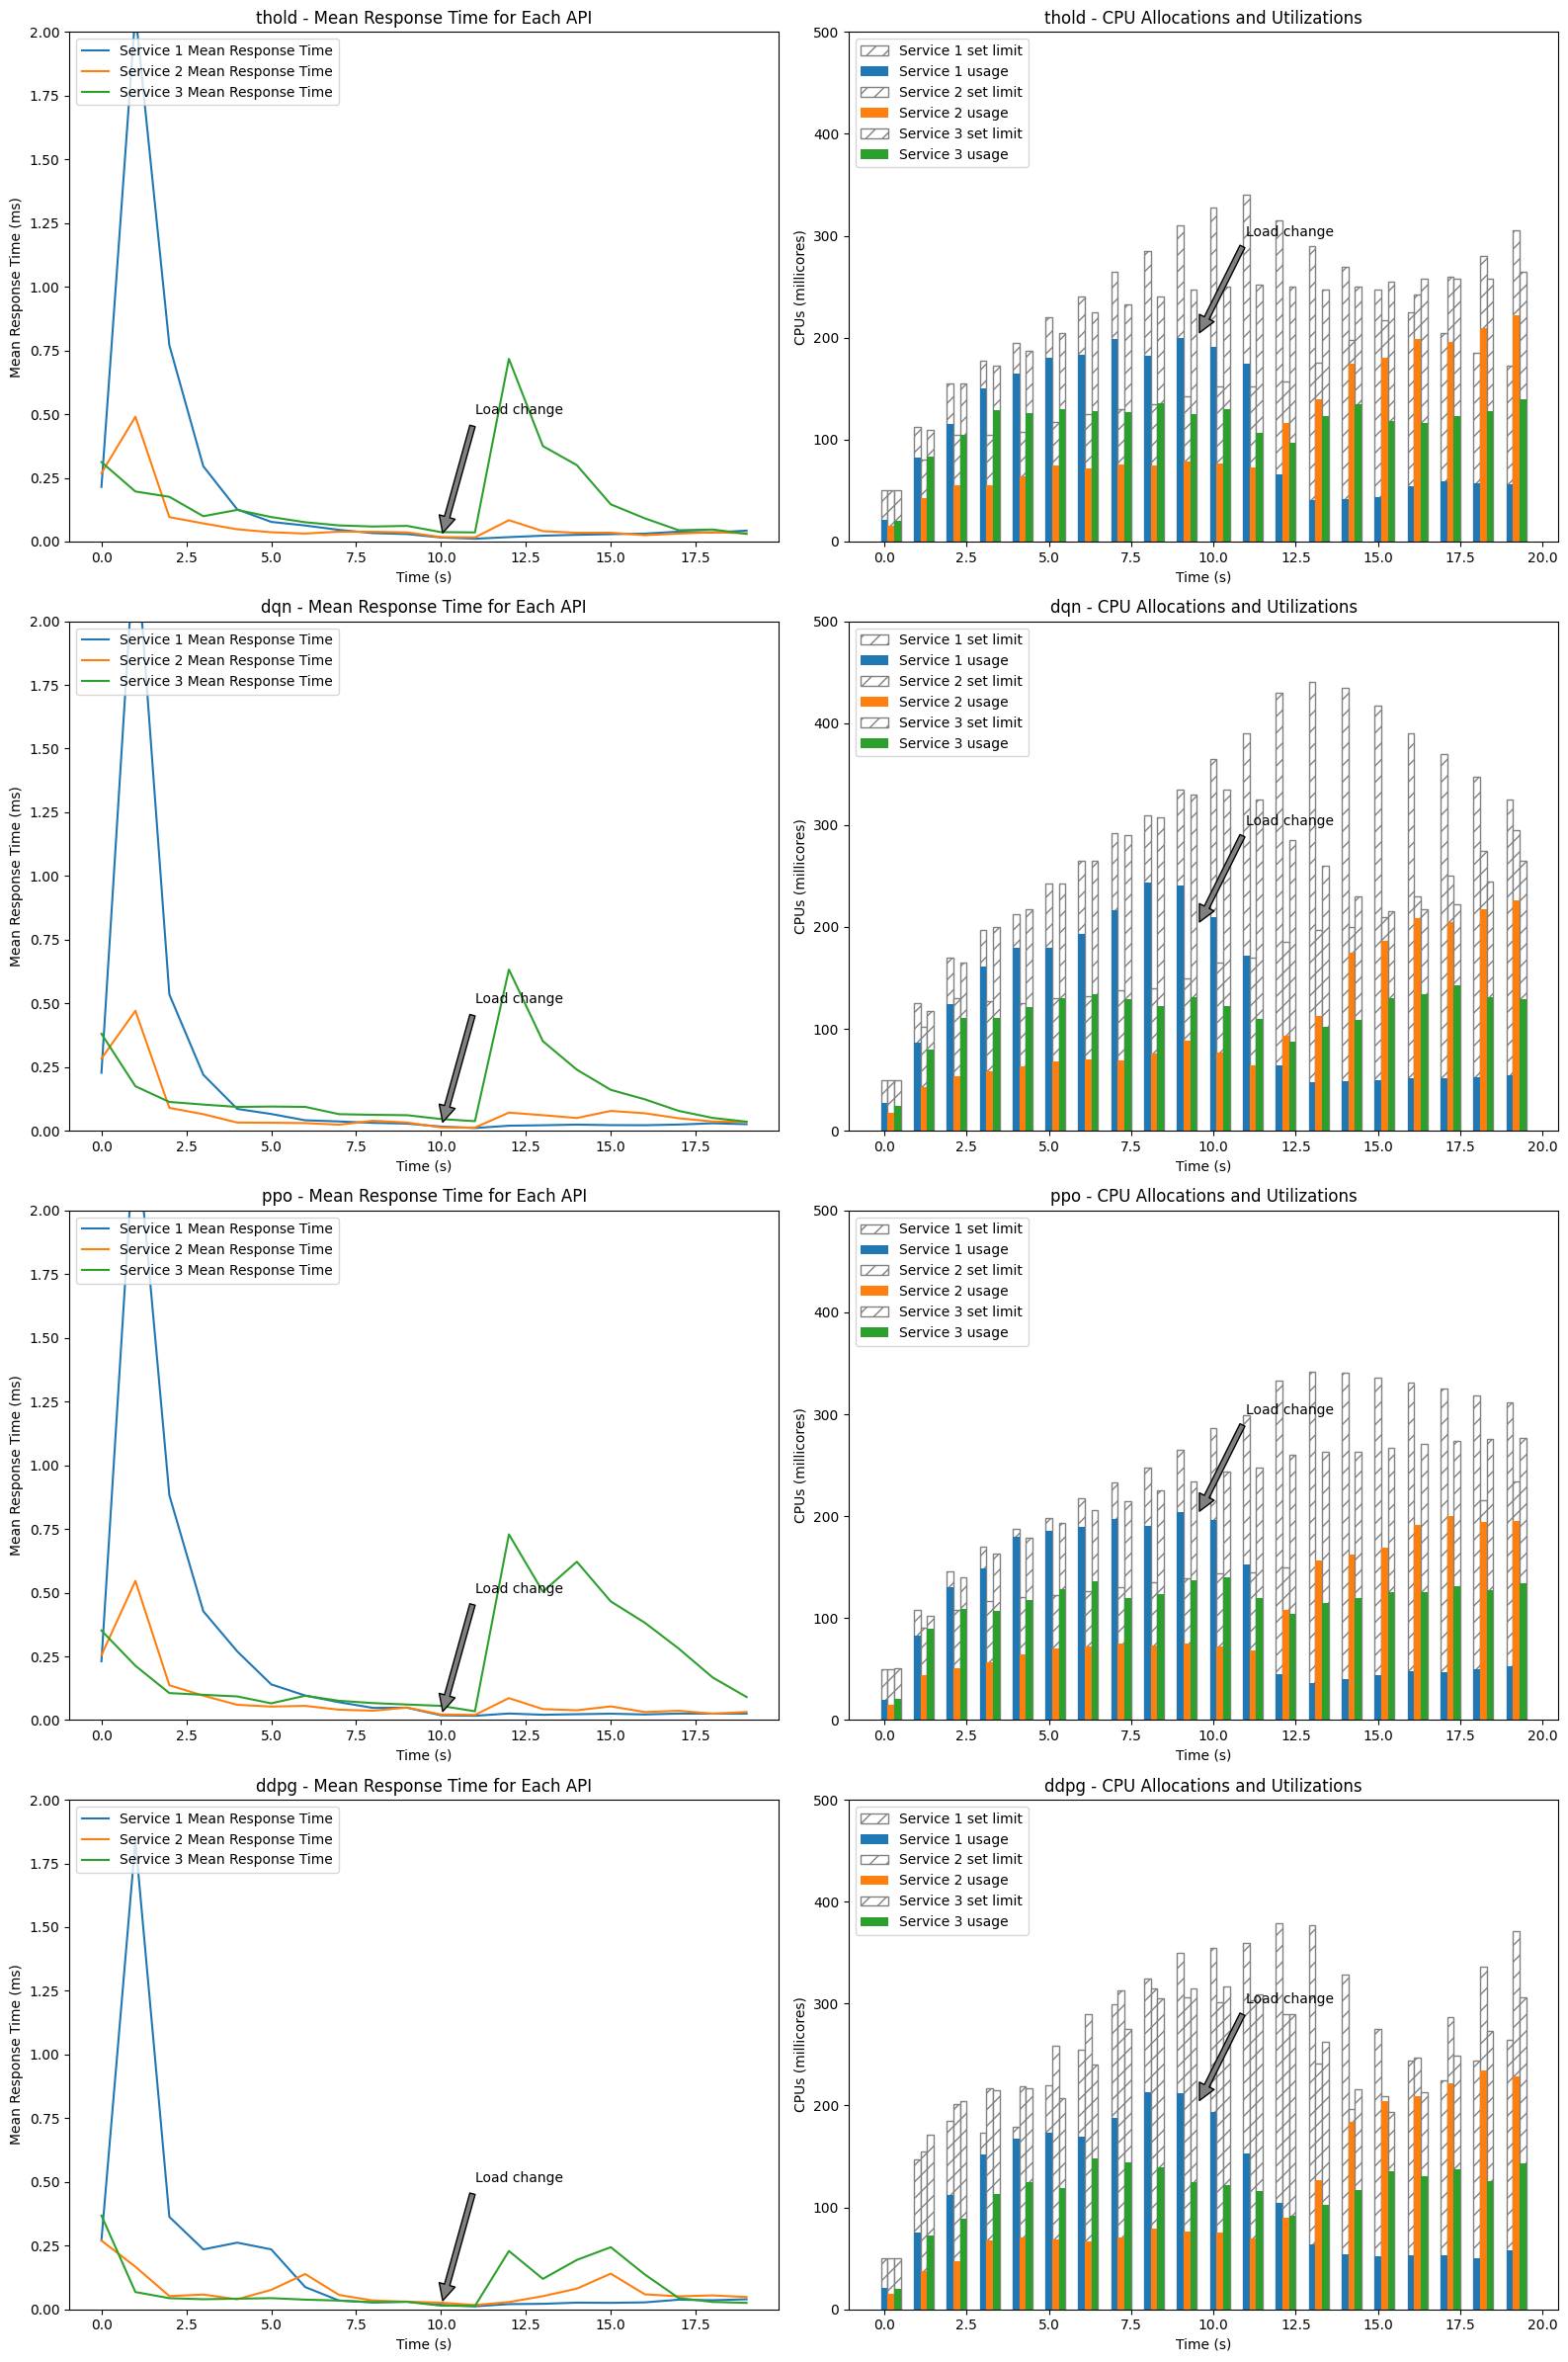

In [37]:
fig, axes = plt.subplots(4, 2, figsize=(16, 24))

for idx, algorithm in enumerate(algorithms):
    response_times = mean_rts_alg[algorithm]
    container_recordings = mean_crec_alg[algorithm]
    time_axis = range(len(container_recordings))
    halfway_point = len(time_axis) // 2

    ax1 = axes[idx, 0]
    for api_id, rts in response_times.items():
        ax1.plot(time_axis, rts, label=f'Service {api_id} Mean Response Time')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Mean Response Time (ms)')
    ax1.set_title(f'{algorithm} - Mean Response Time for Each API')
    ax1.legend(loc='upper left')
    ax1.set_ylim(0, 2)
    ax1.annotate('Load change', xy=(halfway_point, 0.01), xytext=(halfway_point + 1, 0.5),
                 arrowprops=dict(facecolor='gray', shrink=0.05))
  
    ax2 = axes[idx, 1]
    for service_idx, container_recording in enumerate(zip(*container_recordings)):
        cpu_limits, cpu_usages, cpu_percentages = zip(*container_recording)
        ax2.bar(np.array(time_axis) + 0.2 * service_idx, cpu_limits, width=0.2, 
                label=f'Service {service_idx + 1} set limit', hatch='//', color='white', edgecolor='gray')
        ax2.bar(np.array(time_axis) + 0.2 * service_idx, cpu_usages, width=0.2, label=f'Service {service_idx + 1} usage')
    
    ax2.annotate('Load change', xy=(halfway_point - 0.5, 200), xytext=(halfway_point + 1, 300),
                 arrowprops=dict(facecolor='gray', shrink=0.05))
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('CPUs (millicores)')
    ax2.set_title(f'{algorithm} - CPU Allocations and Utilizations')
    ax2.legend(loc='upper left')
    ax2.set_ylim(0, 500)


plt.tight_layout()
plt.show()

In [5]:
for alg in algorithms:
    print(alg, np.mean(np.array(list(mean_rts_alg[str(alg)].values())).flatten()))

thold 0.14326210044907411
dqn 0.1404152634537037
ppo 0.184675340375
ddpg 0.11526824804166666


In [3]:
recordings = 50
container_recordings = []
response_times = {api_id: [] for api_id in range(1, apis + 1)}
nodes = init_nodes(debug=True, custom_label='app=localization-api')
commands = []

for i, load in enumerate(first_loads):
    commands.append(['python', 'src/spam_cluster.py', '--users', str(int(rps * load)), 
                    '--interval', str(interval), '--service', str(i + 1)])

subprocesses = [subprocess.Popen(command) for command in commands]

try:
    for i in range(recordings):
        if i == (recordings // 2):
            for proc in subprocesses:
                proc.terminate()
                proc.wait()
            subprocesses.clear()
            for api_id, load in enumerate(second_loads):
                subprocesses.append(subprocess.Popen(
                    ['python', 'src/spam_cluster.py', '--users', str(int(rps * load)), 
                    '--interval', str(interval), '--service', str(api_id + 1)]))
        start_time = time.time()
        
        for api_id in range(1, apis + 1):
            rts = [rt for rt in get_response_times(USERS, f'{url}/api{api_id}/predict') if rt is not None]
            mean_rt = np.mean(rts) if rts else float('nan')
            response_times[api_id].append(mean_rt)

        
        node_recordings = []
        for id in range(1, apis + 1):
            cpu_limit_all, cpu_all = 0, 0
            for node in nodes:
                node.update_containers(debug=True, custom_label='app=localization-api', reset_containers=True)
                for container_id, (pod_name, _, _) in list(node.get_containers().items()):
                    if f"deployment{id}" in pod_name:
                        (cpu_limit, cpu, cpu_percentage), (_, _, _), (_, _), _ = node.get_container_usage(container_id)
                        cpu_limit_all += cpu_limit
                        cpu_all += cpu

            node_recordings.append((cpu_limit_all, cpu_all, 0))
        container_recordings.append(node_recordings)

        elapsed_time = time.time() - start_time
        time.sleep(max(0, time_step - elapsed_time))
finally:
    for proc in subprocesses:
        proc.terminate()
        proc.wait()


In [4]:
np.mean(np.array(list(response_times.values())).flatten())

0.20845952985185184

In [7]:
pickle.dump(container_recordings, open('results/stupid_hpa/container_recordings.p', 'wb'))
pickle.dump(response_times, open('results/stupid_hpa/response_times.p', 'wb'))

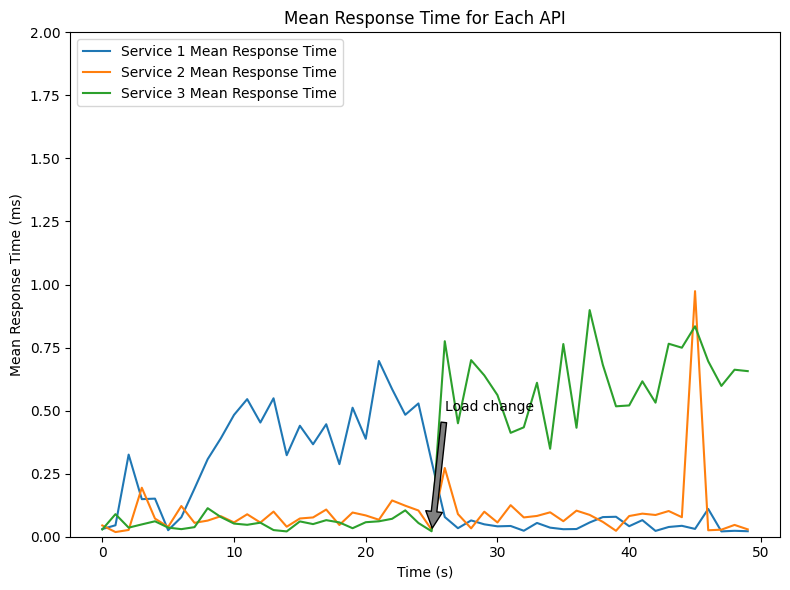

In [5]:
plt.figure(figsize=(8, 6))

time_axis = range(len(response_times[list(response_times.keys())[0]]))
halfway_point = len(time_axis) // 2

for api_id, rts in response_times.items():
    plt.plot(time_axis, rts, label=f'Service {api_id} Mean Response Time')

plt.annotate('Load change', xy=(halfway_point, 0.01), xytext=(halfway_point + 1, 0.5),
             arrowprops=dict(facecolor='gray', shrink=0.05))

plt.xlabel('Time (s)')
plt.ylabel('Mean Response Time (ms)')
plt.title('Mean Response Time for Each API')

plt.legend(loc='upper left')

plt.ylim(0, 2)

plt.tight_layout()
plt.show()

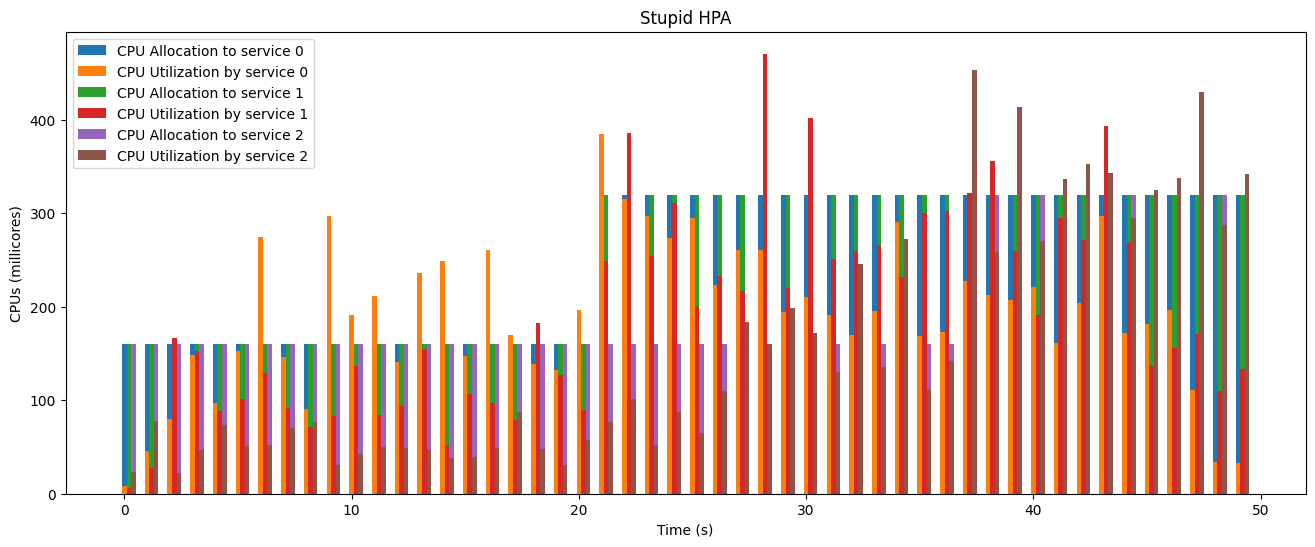

In [6]:
plt.figure(figsize=(16, 6))
for i, container_recording in enumerate(zip(*container_recordings)):
    cpu_limits, cpu, _ = zip(*container_recording)
    plt.bar(np.array(time_axis) + i*0.2, cpu_limits, width=0.2, label=f'CPU Allocation to service {i}')
    plt.bar(np.array(time_axis) + i*0.2, cpu, width=0.2, label=f'CPU Utilization by service {i}')
plt.xlabel('Time (s)')
plt.ylabel('CPUs (millicores)')
plt.title('Stupid HPA')
# plt.xticks(time_axis)
# plt.xticks(range(0, len(time_seconds), tick_interval // time_step), range(0, time_seconds[-1] + 1, tick_interval))

plt.legend()
plt.show()